# Section 5 video 5: Introduction to the Atari environment

Now we were able to solve the cartpole environment it's time to explore other interesting environments. A list with environments available in the OpenAI gym [can be found on this website](https://gym.openai.com/envs/). If you like videogames like me you are probably interested in the Atari environment....

Before you dive into these environments it's important to note that these problems are SUPER difficult. It's hard to define exactly what an agent has to do using traditional computer-vision and manually implemented rules. Imagine how hard it is for a neural network to learn what's good and what's bad while only having access to a system in which it gets rewards every time it does something right. In many environments the reward for an action is VERY delayed. In the game breakout you have to start moving in the right direction while the ball is still going up, otherwise you will miss it when it comes down. As you only get a reward when the ball hits a block you get your reward for moving correctly A LOT of frames later than you performed the action...

Now you know how difficult this environment is I will walk you through te code that is able to solve it. I will go over some interesting things in the code and explain why they are there. Progress is logged to TensorBoard so you can keep up with what your network is learning. 

Note that training this neural network can take a VERY long time. In my case I left my computer on for a whole day!

This is also the reason I put this video in a separate notebook. You could see this video in which I explain the code as a separate section you should follow if you are interested in diving deeper into deep q-networks. If you are not interested in the explanations, feel free to just run this code all at once and look at the result at the end...

### Imports
We start by importing libraries that are familiar to you by now... 

One thing you are probably not familiar with is the scikit-image library. We need this library to resize images and turn the color-images into grayscale images. This will return in the preprocessing step later this section. 

In [1]:
import os
import gym
import random
import numpy as np
import tensorflow as tf
from collections import deque
from skimage.color import rgb2gray
from skimage.transform import resize

### Settings
There are some settings you want to set. Let's go over some things..

#### Defining state
In the cartpole example we based our decision on the most recent observation of the cartpole. With Atari games this is a bit more difficult... If you take one screenshot of a game you can't know if the ball is going up or down, left or right... This is why we use multiple frames for our state. We concatenate them in the last dimension, giving you something that looks like a normal image with multiple feature layers... The amount we concatenate is wat we 

In [2]:
STATE_HISTORY = 4
GAMMA = 0.99

#### Replay memory
To train our agent we need to have a good idea about how our environment works. We thus have a "pre-training/exploring" period in which the agent only takes random steps and our network is not yet trained. We also have a replay memory which has a maximum size to eventually train on well-working states. 

In [3]:
INITIAL_REPLAY_SIZE = 20000  # Number of steps to populate the replay memory before training starts
NUM_REPLAY_MEMORY = 400000  # Number of replay memory the agent uses for training

#### Value network and target network
As you remember we used our neural network to estimate the value of our next state, and used that estimate to update our network again. This can sometimes lead to "unstable" situations, where your network makes a strange decision which keeps going through your network each time you update it. 

This is why we will use a value and a target network here... It boils down on constructing two neural networks with the same layer. To update our target network we use our value network like this: 

> $Qtarget(state,action) = reward + gamma * Qvalue(nextstate, max_action)$

While we train the target network gets better and better at estimating the value of a state. We copy the weights of our target network to the value network every X iterations, where you can define how often this happens. 

We also decide to not train every frame, but every X frames so you can put more playtime in training. 

In [4]:
TARGET_UPDATE_INTERVAL = 10000  # The frequency with which the target network is updated
TRAIN_INTERVAL = 4  # The agent selects X actions between successive updates

### Preprocessing
Now that we set a lot of parameters it's time to think about preprocessing a state. Although the sprites in Atari images look pretty nice and colourful, it's better to turn them into grayscale images to speed up learning. An additional improvement to speed up training is to resize the images a bit (smaller images means faster training). 

Feel free to toy around with frame-width and height later!

In [5]:

FRAME_WIDTH = 84  # Resized frame width
FRAME_HEIGHT = 84  # Resized frame height

def preprocess(observation, last_observation):
    processed_observation = np.maximum(observation, last_observation)
    processed_observation = np.uint8(resize(rgb2gray(processed_observation), (FRAME_WIDTH, FRAME_HEIGHT)) * 255)
    return processed_observation


### Setting up the environment
There are multiple interesting Atari environments. In this case I like the breakout game, so I went for this environment. Feel free to explore what environments work with what network, and how you can explain this. One interesting note about the [Breakout-v0 environment](https://gym.openai.com/envs/Breakout-v0/) is that it randomly skips frames while playing (either 2,3, or 4). This random behaviour can be quite annoying for a neural network that tries to learn how to play a game. The environment `BreakoutDeterministic-v4` always takes 4 frames for each action, and thus might be easier to learn for a neural network...

In [6]:
ENV_NAME = 'Breakout-v0'  
ENV_NAME = 'BreakoutDeterministic-v4'
env = gym.make(ENV_NAME)
num_actions = env.action_space.n

#### Exploring the environment: epsilon-annealing
In this section I explained in what way your agent can explore its environment. Below you can tweak the exploration parameters: from initial epsilon to final epsilon and the amount of steps the agent takes before he reaches its final epsilon...

In [7]:
EXPLORATION_STEPS = 1000000  # Number of steps to decrease epsilon over
INITIAL_EPSILON = 1.0  # Initial epsilon value 
FINAL_EPSILON = 0.1  # Final epsilon value

epsilon = INITIAL_EPSILON
epsilon_step = (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORATION_STEPS

### Global parameters
There are some variables I will make globally accessible to all functions in Python. This includes the current timestep (noted as t), the replay memory (which is a double ended queue to easier remove unneccesary frames), and the parameters we use for the summary we want to write to TensorBoard..

In [8]:
t = 0

# Create replay memory
replay_memory = deque()

# Parameters used for summary
total_reward = 0
total_q_max = 0
total_loss = 0
duration = 0
episode = 0

### Defining our network
With all parameters we build and set you would almost forget that we still have to build a neural network! Remember that we have a value network and a target network. The code below builds the shared part of the architecture we envision. As input we give the state of our network, and as output we want to have an estimation of the value for each action...

In [9]:
def build_network(name):
    with tf.variable_scope(name):
        state_placeholder = tf.placeholder(tf.float32, [None, FRAME_WIDTH, FRAME_HEIGHT, STATE_HISTORY])
        conv1 = tf.layers.conv2d(state_placeholder, 32, (8,8), strides=(4,4), activation=tf.nn.relu, name="firstconvlayer")
        conv2 = tf.layers.conv2d(conv1, 64, (4,4), strides=(2,2), activation=tf.nn.relu, name="secondconvlayer")
        conv3 = tf.layers.conv2d(conv2, 64, (3,3), strides=(1,1), activation=tf.nn.relu, name="thirdconvlayer")
        flattened = tf.contrib.layers.flatten(conv3)
        print("Size flattened layer:")
        print(flattened)
        dense1 = tf.layers.dense(flattened, 512, activation=tf.nn.relu, name="firstdenselayer")
        q_values = tf.layers.dense(dense1, num_actions, name="predictionlayer")
    
    ## Get a collection of all trainable parameters in this scope so we can build an update function for the value and target network
    trainable_parameters = [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith(name)]
    
    return state_placeholder, q_values, trainable_parameters

### Network definition and weight-updating
Time to define the first parts of our network! Below we will build both networks and define a target network update operation...

In [10]:
s, q_values, q_network_weights = build_network("q_network")
st, target_q_values, target_network_weights = build_network("target_network")

## Define target network update operation
update_target_network = [target_network_weights[i].assign(q_network_weights[i]) for i in range(len(target_network_weights))]



Size flattened layer:
Tensor("q_network/Flatten/Reshape:0", shape=(?, 3136), dtype=float32)
Size flattened layer:
Tensor("target_network/Flatten/Reshape:0", shape=(?, 3136), dtype=float32)


### Input and output 
As input we have a state, nextstate, action and the reward the agent got performing that action. Below we define the placeholders and estimated q_value...

In [11]:
a = tf.placeholder(tf.int64, [None])
y = tf.placeholder(tf.float32, [None])

# Convert action to one hot vector
a_one_hot = tf.one_hot(a, num_actions, 1.0, 0.0)

## Use the network we created before to determine the expected value for the specified action
q_value = tf.reduce_sum(tf.multiply(q_values, a_one_hot), reduction_indices=1)


### Loss function
As loss function you can use mean-squared error, but note that this error metric can give us HUGE values if our network makes a large mistake. An error measure that is a bit "smoother" for larger errors is the Huber loss. This loss is quadratic for small errors (between -1 and 1), and linear after that. An image of this can be seen below: 

![huber](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Huber_loss.svg/300px-Huber_loss.svg.png)

The blue line indicates the mean squared error gradients, while the green line indicates the Huber loss. For small errors the lines overlap. 

In [12]:
# Clip the error, the loss is quadratic when the error is in (-1, 1), and linear outside of that region
with tf.variable_scope("huber_loss"):
    error = tf.abs(y - q_value)
    quadratic_part = tf.clip_by_value(error, 0.0, 1.0)
    linear_part = error - quadratic_part
    loss = tf.reduce_mean(0.5 * tf.square(quadratic_part) + linear_part)


### The optimizer
Normally we always use the ADAM optimizer. A downside we did not yet encounter by Adam is that if you encounter a very very sparse situation you can mess up your gradients. It turns out that this is possible using this environment. This is why we use another optimizer: the RMSPropOptimizer. You can find more information about this loss function [on this great blog by Sebastian Ruder](http://ruder.io/optimizing-gradient-descent/). 

In [13]:
LEARNING_RATE = 0.00025  # Learning rate used by RMSProp
MOMENTUM = 0.95  # Momentum used by RMSProp
MIN_GRAD = 0.01  # Constant added to the squared gradient in the denominator of the RMSProp update

optimizer = tf.train.RMSPropOptimizer(LEARNING_RATE, momentum=MOMENTUM, epsilon=MIN_GRAD)
grads_update = optimizer.minimize(loss, var_list=q_network_weights)

### Initial state
As you hopefully remember we use a history of frames as our state. Our initial state consists of a single frame that is repeated for X times. 

In [14]:
def get_initial_state(observation, last_observation):
    processed_observation = np.maximum(observation, last_observation)
    processed_observation = np.uint8(resize(rgb2gray(processed_observation), (FRAME_WIDTH, FRAME_HEIGHT)) * 255)
    state = [processed_observation for _ in range(STATE_HISTORY)]
    return np.dstack(state)

### How do we determine our action? 
At the start of our program we always want to select a random action. This is determined by the INITIAL_REPLAY_SIZE variable defined above. If we are passed this amount we do what we did in the previous videos: draw a number, check if it's bigger than epsilon. If not: we select a random action, else we evaluate our state and select the best action!

In [15]:

def get_action(state, epsilon):
    if epsilon >= random.random() or t < INITIAL_REPLAY_SIZE:
        action = random.randrange(num_actions)
    else:
        action = np.argmax(q_values.eval(feed_dict={s: [np.float32(state / 255.0)]}))

    # Anneal epsilon linearly over time
    if epsilon > FINAL_EPSILON and t >= INITIAL_REPLAY_SIZE:
        epsilon -= epsilon_step

    return action

### Logging to TensorBoard
Above we defined several parameters that are interesting to measure the progress of our neural network: 
- Total reward in an episode: for breakout this is the amount of blocks you can remove with three lives. 
- Episode duration: how many frames can you juggle the ball without dying?
- Episode average max q: it turns out that if we are doing random actions we can't immediately see improvement for our agent. A better metric to watch is the average maximum estimated quality of our state (max of q(s,a)). 
- Average loss: this indicates how well our neural network is learning. Note that as we keep reaching new states we probably don't have a nice loss that goes down like you are expecting. 

In TensorBoard you want to look at the average_maxq value to see how well your network is learning. 

In [16]:
SAVE_SUMMARY_PATH = 'graphs/dqn/atari'

### SUMMARY STUFF
episode_total_reward = tf.placeholder(tf.float32)
episode_duration = tf.placeholder(tf.float32)
episode_avg_max_q = tf.placeholder(tf.float32)
episode_avg_loss = tf.placeholder(tf.float32)


tf.summary.scalar('total_reward', episode_total_reward)
tf.summary.scalar('average_maxq', episode_avg_max_q)
tf.summary.scalar('duration', episode_duration)
tf.summary.scalar('loss', episode_avg_loss)

summary_op = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter(SAVE_SUMMARY_PATH, tf.get_default_graph())


### Starting a session
Now that we defined a network, losses, and have a summary it's time to start our session and set the variables for the two networks to the same value.

In [17]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
updated_variables = sess.run(update_target_network)

### Training a network
Time to train our network. We pass the replay memory to a train_network function and feed the states, actions, and the estimated values by the target network to our normal network!

In [18]:
BATCH_SIZE = 32  

def train_network(replay_memory):
    state_batch = []
    action_batch = []
    reward_batch = []
    next_state_batch = []
    terminal_batch = []
    y_batch = []

    # Sample random minibatch of transition from replay memory
    minibatch = random.sample(replay_memory, BATCH_SIZE)
    for data in minibatch:
        state_batch.append(data[0])
        action_batch.append(data[1])
        reward_batch.append(data[2])
        next_state_batch.append(data[3])
        terminal_batch.append(data[4])

    # Convert True to 1, False to 0
    terminal_batch = np.array(terminal_batch) + 0

    target_q_values_batch = target_q_values.eval(
        feed_dict={st: np.float32(np.array(next_state_batch) / 255.0)})
    y_batch = reward_batch + (1 - terminal_batch) * GAMMA * np.max(target_q_values_batch, axis=1)

    local_loss, _ = sess.run([loss, grads_update], feed_dict={
        s: np.float32(np.array(state_batch) / 255.0),
        a: action_batch,
        y: y_batch
    })
    
    
    return local_loss

### Time to run our network!
We defined everything! Now we will run our neural network for a predetermined number of episodes and see how well it is working afterwards. I set the number of episodes to a value that takes me about of day (24 hours) to train, and gives you a result that... kind of works. 

The code below is very similar to the code we used for cartpole in the previous video, so I won't go through it in my written description. 

In [ ]:
NUM_EPISODES = 15000  # Number of episodes the agent plays
NO_OP_STEPS = 30  

for _ in range(NUM_EPISODES):
    ## Reset the network and get an initial state
    terminal = False
    observation = env.reset()
    for _ in range(random.randint(1, NO_OP_STEPS)):
        last_observation = observation
        observation, _, _, _ = env.step(0)  # Do nothing
    state = get_initial_state(observation, last_observation)
    
    ### Keep running till we lose all of our lives
    while not terminal:
        last_observation = observation
        action = get_action(state, epsilon)
        
        observation, reward, terminal, _ = env.step(action)
        processed_observation = preprocess(observation, last_observation)

        next_state = np.dstack((state[:, :, 1:], processed_observation))

        # Store transition in replay memory
        replay_memory.append((state, action, reward, next_state, terminal))

        ## If the replay memory is too large, remove the first part of the memory
        if len(replay_memory) > NUM_REPLAY_MEMORY:
            replay_memory.popleft()

        ## If we have enough frames to start learning, train!
        if t >= INITIAL_REPLAY_SIZE:
            if t % TRAIN_INTERVAL == 0:
                total_loss += train_network(replay_memory)

            ## Set the target network variables equal to what we trained
            if t % TARGET_UPDATE_INTERVAL == 0:
                sess.run(update_target_network)
                
        ## Increase variables like reward and q
        total_reward += reward
        total_q_max += np.max(q_values.eval(feed_dict={s: [np.float32(state / 255.0)]}))
        duration += 1

        if terminal:
            ## Write summary for TensorBoard
            if t >= INITIAL_REPLAY_SIZE:
                summary_str = sess.run(summary_op, feed_dict={episode_total_reward: total_reward, episode_avg_max_q: total_q_max/float(duration), episode_duration: duration , episode_avg_loss: total_loss/duration})
                summary_writer.add_summary(summary_str, episode + 1)

            ## Debug
            print("Finished episode %d/%d which took %d frames" % (episode+1, NUM_EPISODES, duration))
            
            ## Reset variables
            total_reward = 0
            total_q_max = 0
            total_loss = 0
            duration = 0
            episode += 1

        ## Increase timestep and set next observed state as current state
        t += 1
        state = next_state

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Finished episode 1/15000 which took 213 frames
Finished episode 2/15000 which took 165 frames
Finished episode 3/15000 which took 310 frames
Finished episode 4/15000 which took 162 frames
Finished episode 5/15000 which took 137 frames
Finished episode 6/15000 which took 158 frames
Finished episode 7/15000 which took 126 frames
Finished episode 8/15000 which took 182 frames
Finished episode 9/15000 which took 219 frames
Finished episode 10/15000 which took 172 frames
Finished episode 11/15000 which took 226 frames
Finished episode 12/15000 which took 222 frames
Finished episode 13/15000 which took 165 frames
Finished episode 14/15000 which took 145 frames
Finished episode 15/15000 which took 178 frames
Finished episode 16/15000 which took 135 frames
Finished episode 17/15000 which took 141 frames
Finished episode 18/15000 which took 190 frames
Finished episode 19/15000 which took 188 frames
Finished episode 20/15000 which took 211 frames
Finished episode 21/15000 which took 128 frames
F

Finished episode 171/15000 which took 133 frames
Finished episode 172/15000 which took 180 frames
Finished episode 173/15000 which took 187 frames
Finished episode 174/15000 which took 142 frames
Finished episode 175/15000 which took 199 frames
Finished episode 176/15000 which took 135 frames
Finished episode 177/15000 which took 208 frames
Finished episode 178/15000 which took 136 frames
Finished episode 179/15000 which took 134 frames
Finished episode 180/15000 which took 224 frames
Finished episode 181/15000 which took 253 frames
Finished episode 182/15000 which took 186 frames
Finished episode 183/15000 which took 201 frames
Finished episode 184/15000 which took 199 frames
Finished episode 185/15000 which took 226 frames
Finished episode 186/15000 which took 172 frames
Finished episode 187/15000 which took 140 frames
Finished episode 188/15000 which took 163 frames
Finished episode 189/15000 which took 130 frames
Finished episode 190/15000 which took 216 frames
Finished episode 191

Finished episode 339/15000 which took 208 frames
Finished episode 340/15000 which took 206 frames
Finished episode 341/15000 which took 180 frames
Finished episode 342/15000 which took 165 frames
Finished episode 343/15000 which took 170 frames
Finished episode 344/15000 which took 236 frames
Finished episode 345/15000 which took 133 frames
Finished episode 346/15000 which took 201 frames
Finished episode 347/15000 which took 160 frames
Finished episode 348/15000 which took 162 frames
Finished episode 349/15000 which took 148 frames
Finished episode 350/15000 which took 153 frames
Finished episode 351/15000 which took 133 frames
Finished episode 352/15000 which took 136 frames
Finished episode 353/15000 which took 308 frames
Finished episode 354/15000 which took 202 frames
Finished episode 355/15000 which took 212 frames
Finished episode 356/15000 which took 140 frames
Finished episode 357/15000 which took 222 frames
Finished episode 358/15000 which took 182 frames
Finished episode 359

Finished episode 507/15000 which took 170 frames
Finished episode 508/15000 which took 161 frames
Finished episode 509/15000 which took 152 frames
Finished episode 510/15000 which took 234 frames
Finished episode 511/15000 which took 192 frames
Finished episode 512/15000 which took 213 frames
Finished episode 513/15000 which took 200 frames
Finished episode 514/15000 which took 270 frames
Finished episode 515/15000 which took 282 frames
Finished episode 516/15000 which took 161 frames
Finished episode 517/15000 which took 204 frames
Finished episode 518/15000 which took 130 frames
Finished episode 519/15000 which took 175 frames
Finished episode 520/15000 which took 170 frames
Finished episode 521/15000 which took 203 frames
Finished episode 522/15000 which took 218 frames
Finished episode 523/15000 which took 133 frames
Finished episode 524/15000 which took 180 frames
Finished episode 525/15000 which took 157 frames
Finished episode 526/15000 which took 163 frames
Finished episode 527

Finished episode 675/15000 which took 178 frames
Finished episode 676/15000 which took 257 frames
Finished episode 677/15000 which took 169 frames
Finished episode 678/15000 which took 146 frames
Finished episode 679/15000 which took 264 frames
Finished episode 680/15000 which took 170 frames
Finished episode 681/15000 which took 197 frames
Finished episode 682/15000 which took 140 frames
Finished episode 683/15000 which took 165 frames
Finished episode 684/15000 which took 177 frames
Finished episode 685/15000 which took 145 frames
Finished episode 686/15000 which took 143 frames
Finished episode 687/15000 which took 134 frames
Finished episode 688/15000 which took 286 frames
Finished episode 689/15000 which took 136 frames
Finished episode 690/15000 which took 169 frames
Finished episode 691/15000 which took 240 frames
Finished episode 692/15000 which took 158 frames
Finished episode 693/15000 which took 129 frames
Finished episode 694/15000 which took 193 frames
Finished episode 695

Finished episode 843/15000 which took 181 frames
Finished episode 844/15000 which took 130 frames
Finished episode 845/15000 which took 173 frames
Finished episode 846/15000 which took 209 frames
Finished episode 847/15000 which took 126 frames
Finished episode 848/15000 which took 231 frames
Finished episode 849/15000 which took 143 frames
Finished episode 850/15000 which took 211 frames
Finished episode 851/15000 which took 202 frames
Finished episode 852/15000 which took 144 frames
Finished episode 853/15000 which took 143 frames
Finished episode 854/15000 which took 201 frames
Finished episode 855/15000 which took 127 frames
Finished episode 856/15000 which took 185 frames
Finished episode 857/15000 which took 234 frames
Finished episode 858/15000 which took 179 frames
Finished episode 859/15000 which took 130 frames
Finished episode 860/15000 which took 163 frames
Finished episode 861/15000 which took 136 frames
Finished episode 862/15000 which took 251 frames
Finished episode 863

Finished episode 1010/15000 which took 216 frames
Finished episode 1011/15000 which took 238 frames
Finished episode 1012/15000 which took 130 frames
Finished episode 1013/15000 which took 130 frames
Finished episode 1014/15000 which took 221 frames
Finished episode 1015/15000 which took 135 frames
Finished episode 1016/15000 which took 136 frames
Finished episode 1017/15000 which took 129 frames
Finished episode 1018/15000 which took 142 frames
Finished episode 1019/15000 which took 192 frames
Finished episode 1020/15000 which took 131 frames
Finished episode 1021/15000 which took 131 frames
Finished episode 1022/15000 which took 302 frames
Finished episode 1023/15000 which took 133 frames
Finished episode 1024/15000 which took 156 frames
Finished episode 1025/15000 which took 134 frames
Finished episode 1026/15000 which took 238 frames
Finished episode 1027/15000 which took 134 frames
Finished episode 1028/15000 which took 153 frames
Finished episode 1029/15000 which took 262 frames


Finished episode 1174/15000 which took 140 frames
Finished episode 1175/15000 which took 160 frames
Finished episode 1176/15000 which took 142 frames
Finished episode 1177/15000 which took 224 frames
Finished episode 1178/15000 which took 132 frames
Finished episode 1179/15000 which took 125 frames
Finished episode 1180/15000 which took 135 frames
Finished episode 1181/15000 which took 232 frames
Finished episode 1182/15000 which took 128 frames
Finished episode 1183/15000 which took 128 frames
Finished episode 1184/15000 which took 137 frames
Finished episode 1185/15000 which took 174 frames
Finished episode 1186/15000 which took 222 frames
Finished episode 1187/15000 which took 124 frames
Finished episode 1188/15000 which took 186 frames
Finished episode 1189/15000 which took 137 frames
Finished episode 1190/15000 which took 153 frames
Finished episode 1191/15000 which took 139 frames
Finished episode 1192/15000 which took 136 frames
Finished episode 1193/15000 which took 192 frames


Finished episode 1338/15000 which took 146 frames
Finished episode 1339/15000 which took 129 frames
Finished episode 1340/15000 which took 197 frames
Finished episode 1341/15000 which took 206 frames
Finished episode 1342/15000 which took 138 frames
Finished episode 1343/15000 which took 154 frames
Finished episode 1344/15000 which took 205 frames
Finished episode 1345/15000 which took 160 frames
Finished episode 1346/15000 which took 170 frames
Finished episode 1347/15000 which took 163 frames
Finished episode 1348/15000 which took 149 frames
Finished episode 1349/15000 which took 143 frames
Finished episode 1350/15000 which took 137 frames
Finished episode 1351/15000 which took 237 frames
Finished episode 1352/15000 which took 131 frames
Finished episode 1353/15000 which took 137 frames
Finished episode 1354/15000 which took 151 frames
Finished episode 1355/15000 which took 167 frames
Finished episode 1356/15000 which took 232 frames
Finished episode 1357/15000 which took 139 frames


Finished episode 1502/15000 which took 140 frames
Finished episode 1503/15000 which took 250 frames
Finished episode 1504/15000 which took 326 frames
Finished episode 1505/15000 which took 124 frames
Finished episode 1506/15000 which took 129 frames
Finished episode 1507/15000 which took 137 frames
Finished episode 1508/15000 which took 145 frames
Finished episode 1509/15000 which took 162 frames
Finished episode 1510/15000 which took 297 frames
Finished episode 1511/15000 which took 208 frames
Finished episode 1512/15000 which took 174 frames
Finished episode 1513/15000 which took 144 frames
Finished episode 1514/15000 which took 186 frames
Finished episode 1515/15000 which took 280 frames
Finished episode 1516/15000 which took 122 frames
Finished episode 1517/15000 which took 181 frames
Finished episode 1518/15000 which took 136 frames
Finished episode 1519/15000 which took 352 frames
Finished episode 1520/15000 which took 203 frames
Finished episode 1521/15000 which took 130 frames


Finished episode 1666/15000 which took 140 frames
Finished episode 1667/15000 which took 130 frames
Finished episode 1668/15000 which took 137 frames
Finished episode 1669/15000 which took 162 frames
Finished episode 1670/15000 which took 180 frames
Finished episode 1671/15000 which took 184 frames
Finished episode 1672/15000 which took 255 frames
Finished episode 1673/15000 which took 227 frames
Finished episode 1674/15000 which took 241 frames
Finished episode 1675/15000 which took 160 frames
Finished episode 1676/15000 which took 133 frames
Finished episode 1677/15000 which took 135 frames
Finished episode 1678/15000 which took 192 frames
Finished episode 1679/15000 which took 136 frames
Finished episode 1680/15000 which took 183 frames
Finished episode 1681/15000 which took 165 frames
Finished episode 1682/15000 which took 204 frames
Finished episode 1683/15000 which took 129 frames
Finished episode 1684/15000 which took 225 frames
Finished episode 1685/15000 which took 128 frames


Finished episode 1830/15000 which took 134 frames
Finished episode 1831/15000 which took 127 frames
Finished episode 1832/15000 which took 126 frames
Finished episode 1833/15000 which took 180 frames
Finished episode 1834/15000 which took 226 frames
Finished episode 1835/15000 which took 302 frames
Finished episode 1836/15000 which took 195 frames
Finished episode 1837/15000 which took 132 frames
Finished episode 1838/15000 which took 181 frames
Finished episode 1839/15000 which took 133 frames
Finished episode 1840/15000 which took 208 frames
Finished episode 1841/15000 which took 281 frames
Finished episode 1842/15000 which took 205 frames
Finished episode 1843/15000 which took 260 frames
Finished episode 1844/15000 which took 136 frames
Finished episode 1845/15000 which took 259 frames
Finished episode 1846/15000 which took 278 frames
Finished episode 1847/15000 which took 128 frames
Finished episode 1848/15000 which took 181 frames
Finished episode 1849/15000 which took 163 frames


Finished episode 1994/15000 which took 202 frames
Finished episode 1995/15000 which took 312 frames
Finished episode 1996/15000 which took 248 frames
Finished episode 1997/15000 which took 130 frames
Finished episode 1998/15000 which took 179 frames
Finished episode 1999/15000 which took 204 frames
Finished episode 2000/15000 which took 140 frames
Finished episode 2001/15000 which took 230 frames
Finished episode 2002/15000 which took 192 frames
Finished episode 2003/15000 which took 186 frames
Finished episode 2004/15000 which took 128 frames
Finished episode 2005/15000 which took 209 frames
Finished episode 2006/15000 which took 194 frames
Finished episode 2007/15000 which took 156 frames
Finished episode 2008/15000 which took 135 frames
Finished episode 2009/15000 which took 204 frames
Finished episode 2010/15000 which took 135 frames
Finished episode 2011/15000 which took 183 frames
Finished episode 2012/15000 which took 250 frames
Finished episode 2013/15000 which took 131 frames


Finished episode 2158/15000 which took 158 frames
Finished episode 2159/15000 which took 133 frames
Finished episode 2160/15000 which took 157 frames
Finished episode 2161/15000 which took 203 frames
Finished episode 2162/15000 which took 133 frames
Finished episode 2163/15000 which took 164 frames
Finished episode 2164/15000 which took 165 frames
Finished episode 2165/15000 which took 137 frames
Finished episode 2166/15000 which took 157 frames
Finished episode 2167/15000 which took 178 frames
Finished episode 2168/15000 which took 159 frames
Finished episode 2169/15000 which took 185 frames
Finished episode 2170/15000 which took 156 frames
Finished episode 2171/15000 which took 203 frames
Finished episode 2172/15000 which took 124 frames
Finished episode 2173/15000 which took 138 frames
Finished episode 2174/15000 which took 178 frames
Finished episode 2175/15000 which took 197 frames
Finished episode 2176/15000 which took 134 frames
Finished episode 2177/15000 which took 133 frames


Finished episode 2322/15000 which took 130 frames
Finished episode 2323/15000 which took 129 frames
Finished episode 2324/15000 which took 129 frames
Finished episode 2325/15000 which took 136 frames
Finished episode 2326/15000 which took 217 frames
Finished episode 2327/15000 which took 140 frames
Finished episode 2328/15000 which took 143 frames
Finished episode 2329/15000 which took 315 frames
Finished episode 2330/15000 which took 206 frames
Finished episode 2331/15000 which took 161 frames
Finished episode 2332/15000 which took 143 frames
Finished episode 2333/15000 which took 202 frames
Finished episode 2334/15000 which took 137 frames
Finished episode 2335/15000 which took 186 frames
Finished episode 2336/15000 which took 186 frames
Finished episode 2337/15000 which took 133 frames
Finished episode 2338/15000 which took 139 frames
Finished episode 2339/15000 which took 275 frames
Finished episode 2340/15000 which took 366 frames
Finished episode 2341/15000 which took 272 frames


Finished episode 2486/15000 which took 127 frames
Finished episode 2487/15000 which took 203 frames
Finished episode 2488/15000 which took 169 frames
Finished episode 2489/15000 which took 167 frames
Finished episode 2490/15000 which took 210 frames
Finished episode 2491/15000 which took 131 frames
Finished episode 2492/15000 which took 144 frames
Finished episode 2493/15000 which took 246 frames
Finished episode 2494/15000 which took 185 frames
Finished episode 2495/15000 which took 143 frames
Finished episode 2496/15000 which took 138 frames
Finished episode 2497/15000 which took 136 frames
Finished episode 2498/15000 which took 171 frames
Finished episode 2499/15000 which took 163 frames
Finished episode 2500/15000 which took 160 frames
Finished episode 2501/15000 which took 143 frames
Finished episode 2502/15000 which took 181 frames
Finished episode 2503/15000 which took 174 frames
Finished episode 2504/15000 which took 134 frames
Finished episode 2505/15000 which took 200 frames


Finished episode 2650/15000 which took 128 frames
Finished episode 2651/15000 which took 221 frames
Finished episode 2652/15000 which took 131 frames
Finished episode 2653/15000 which took 223 frames
Finished episode 2654/15000 which took 139 frames
Finished episode 2655/15000 which took 135 frames
Finished episode 2656/15000 which took 208 frames
Finished episode 2657/15000 which took 159 frames
Finished episode 2658/15000 which took 239 frames
Finished episode 2659/15000 which took 134 frames
Finished episode 2660/15000 which took 230 frames
Finished episode 2661/15000 which took 126 frames
Finished episode 2662/15000 which took 155 frames
Finished episode 2663/15000 which took 213 frames
Finished episode 2664/15000 which took 188 frames
Finished episode 2665/15000 which took 254 frames
Finished episode 2666/15000 which took 146 frames
Finished episode 2667/15000 which took 186 frames
Finished episode 2668/15000 which took 136 frames
Finished episode 2669/15000 which took 251 frames


Finished episode 2814/15000 which took 143 frames
Finished episode 2815/15000 which took 214 frames
Finished episode 2816/15000 which took 140 frames
Finished episode 2817/15000 which took 142 frames
Finished episode 2818/15000 which took 164 frames
Finished episode 2819/15000 which took 145 frames
Finished episode 2820/15000 which took 336 frames
Finished episode 2821/15000 which took 380 frames
Finished episode 2822/15000 which took 181 frames
Finished episode 2823/15000 which took 167 frames
Finished episode 2824/15000 which took 132 frames
Finished episode 2825/15000 which took 171 frames
Finished episode 2826/15000 which took 130 frames
Finished episode 2827/15000 which took 259 frames
Finished episode 2828/15000 which took 185 frames
Finished episode 2829/15000 which took 169 frames
Finished episode 2830/15000 which took 195 frames
Finished episode 2831/15000 which took 304 frames
Finished episode 2832/15000 which took 232 frames
Finished episode 2833/15000 which took 144 frames


Finished episode 2978/15000 which took 335 frames
Finished episode 2979/15000 which took 145 frames
Finished episode 2980/15000 which took 136 frames
Finished episode 2981/15000 which took 128 frames
Finished episode 2982/15000 which took 138 frames
Finished episode 2983/15000 which took 137 frames
Finished episode 2984/15000 which took 262 frames
Finished episode 2985/15000 which took 161 frames
Finished episode 2986/15000 which took 141 frames
Finished episode 2987/15000 which took 144 frames
Finished episode 2988/15000 which took 220 frames
Finished episode 2989/15000 which took 131 frames
Finished episode 2990/15000 which took 134 frames
Finished episode 2991/15000 which took 189 frames
Finished episode 2992/15000 which took 406 frames
Finished episode 2993/15000 which took 272 frames
Finished episode 2994/15000 which took 211 frames
Finished episode 2995/15000 which took 133 frames
Finished episode 2996/15000 which took 156 frames
Finished episode 2997/15000 which took 137 frames


Finished episode 3142/15000 which took 132 frames
Finished episode 3143/15000 which took 164 frames
Finished episode 3144/15000 which took 210 frames
Finished episode 3145/15000 which took 188 frames
Finished episode 3146/15000 which took 167 frames
Finished episode 3147/15000 which took 129 frames
Finished episode 3148/15000 which took 208 frames
Finished episode 3149/15000 which took 248 frames
Finished episode 3150/15000 which took 163 frames
Finished episode 3151/15000 which took 181 frames
Finished episode 3152/15000 which took 136 frames
Finished episode 3153/15000 which took 144 frames
Finished episode 3154/15000 which took 134 frames
Finished episode 3155/15000 which took 229 frames
Finished episode 3156/15000 which took 187 frames
Finished episode 3157/15000 which took 160 frames
Finished episode 3158/15000 which took 243 frames
Finished episode 3159/15000 which took 182 frames
Finished episode 3160/15000 which took 237 frames
Finished episode 3161/15000 which took 185 frames


Finished episode 3306/15000 which took 158 frames
Finished episode 3307/15000 which took 186 frames
Finished episode 3308/15000 which took 137 frames
Finished episode 3309/15000 which took 241 frames
Finished episode 3310/15000 which took 148 frames
Finished episode 3311/15000 which took 175 frames
Finished episode 3312/15000 which took 183 frames
Finished episode 3313/15000 which took 175 frames
Finished episode 3314/15000 which took 146 frames
Finished episode 3315/15000 which took 161 frames
Finished episode 3316/15000 which took 288 frames
Finished episode 3317/15000 which took 152 frames
Finished episode 3318/15000 which took 265 frames
Finished episode 3319/15000 which took 173 frames
Finished episode 3320/15000 which took 127 frames
Finished episode 3321/15000 which took 177 frames
Finished episode 3322/15000 which took 128 frames
Finished episode 3323/15000 which took 166 frames
Finished episode 3324/15000 which took 167 frames
Finished episode 3325/15000 which took 216 frames


### Testing our code
Time to test our code for a certain amount of frames! We follow the same procedure as during the training and inference with the cartpole environment. This time we can directly append the observation to a history of frames as these are the same...

In [24]:
MAX_FRAMES_TEST = 300
frames = list()

observation = env.reset()

last_observation = observation
observation, _, _, _ = env.step(1) 
state = get_initial_state(observation, last_observation)
for _ in range(MAX_FRAMES_TEST):
    ## Perform action etc
    last_observation = observation
    action = np.argmax(q_values.eval(feed_dict={s: [np.float32(state / 255.0)]}))
    observation, _, terminal, _ = env.step(action)
    processed_observation = preprocess(observation, last_observation)
    state = np.dstack((state[:, :, 1:], processed_observation))
    
    ## Append frame for replay gif
    frames.append(observation)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


### Plotting the result
Let's plot the result as a gif, show it and save it to our harddisk. 


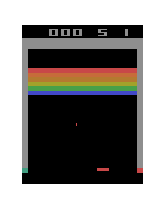
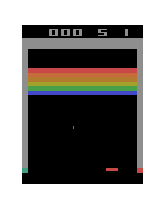
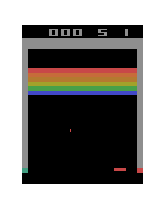
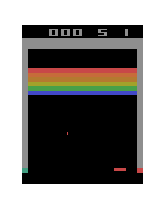
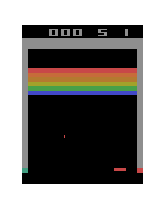
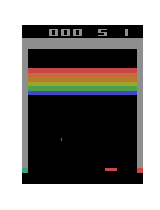
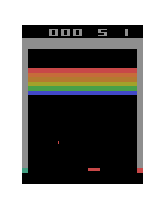
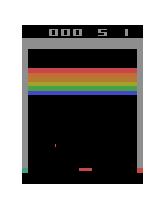
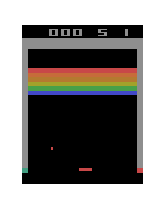
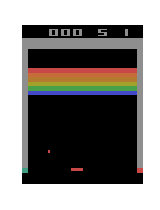
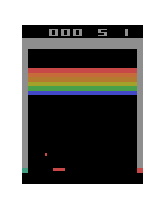
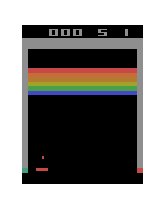
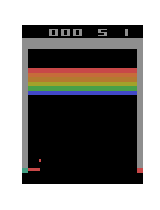
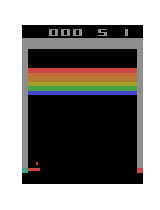
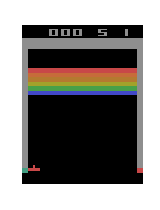
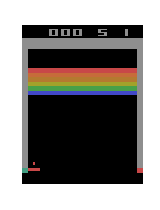
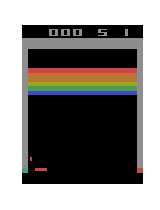
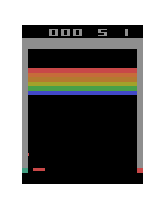
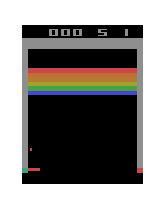
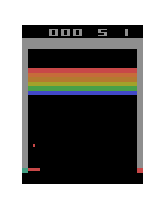
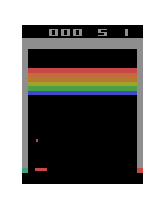
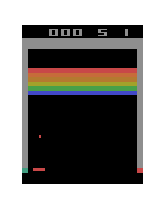
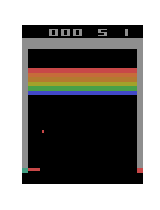
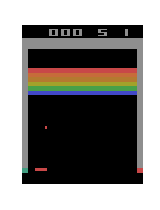
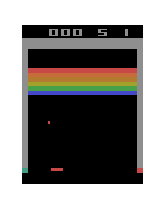
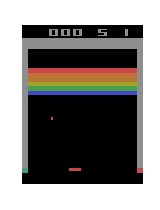
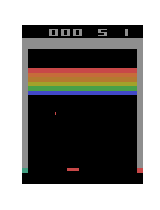
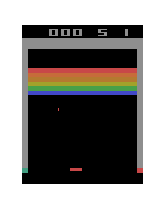
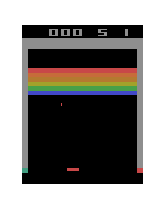
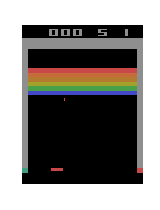
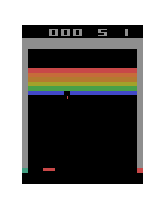
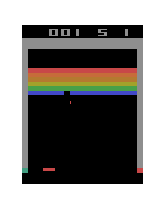
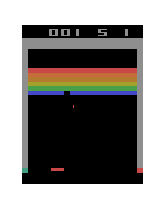
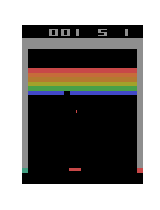
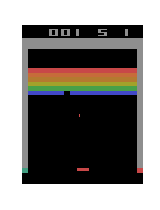
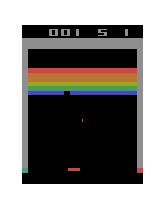
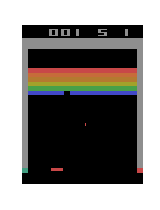
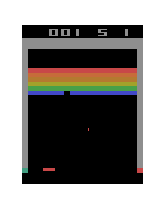
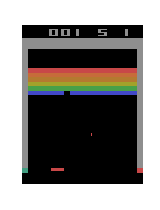
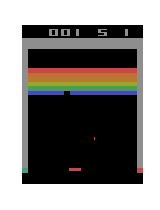
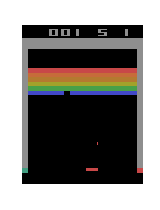
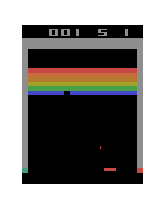
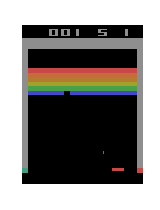
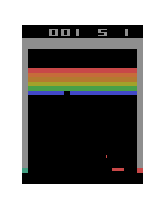
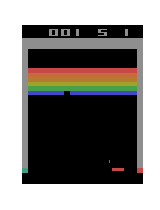
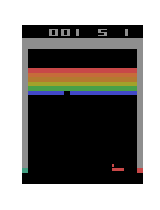
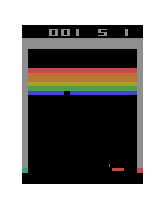
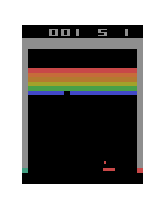
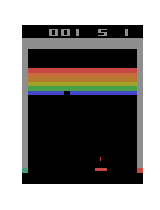
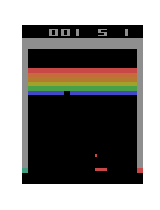
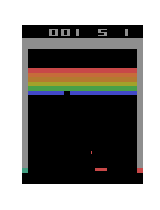
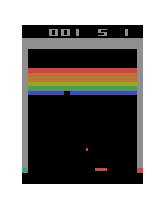
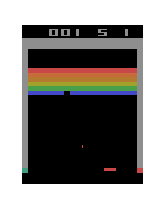
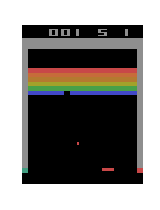
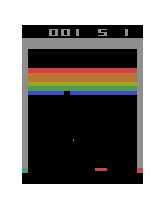
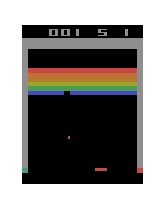
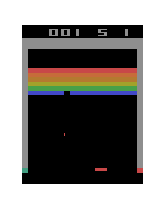
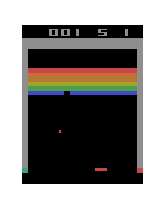
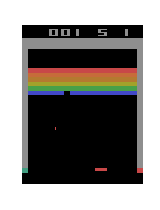
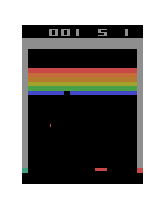
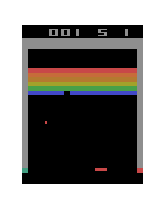
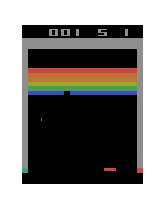
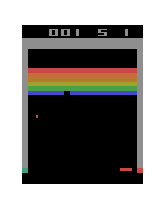
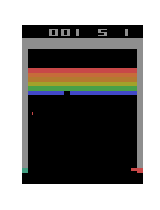
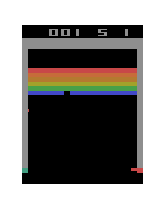
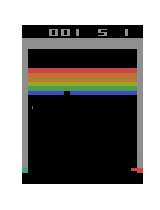
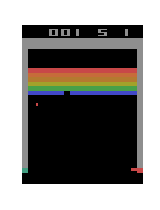
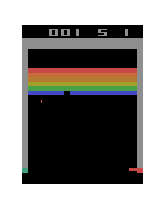
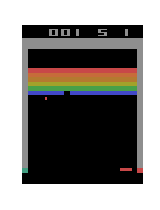
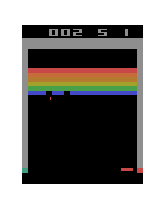
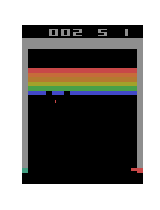
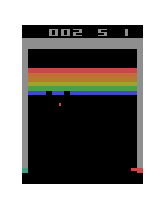
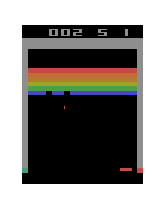
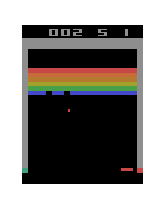
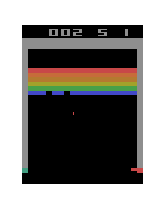
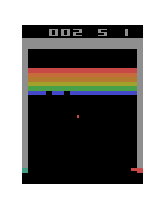
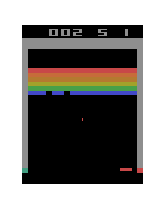
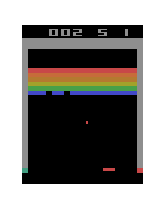
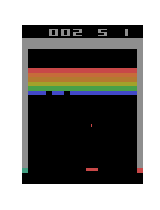
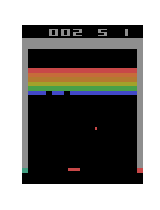
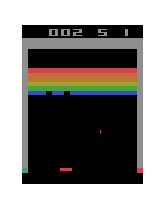
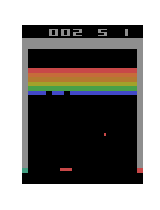
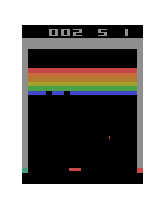
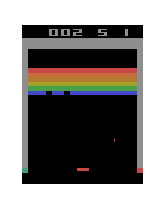
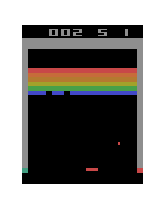
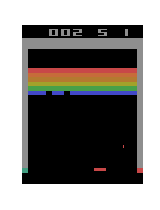
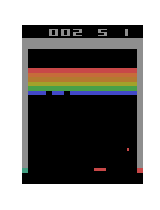
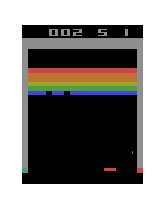
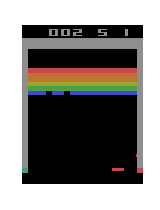
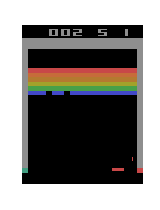
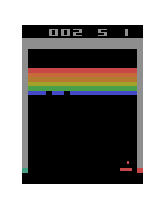
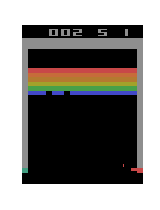
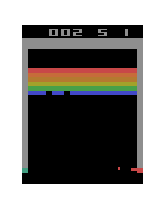
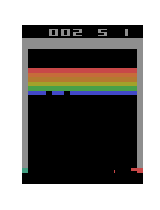
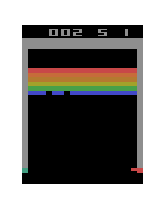
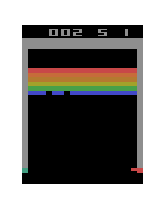
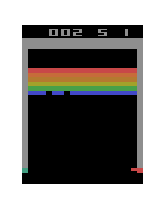
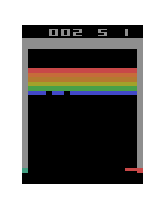
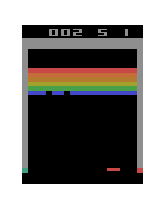
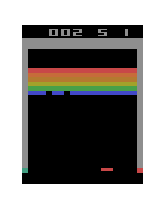
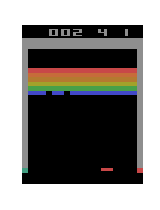
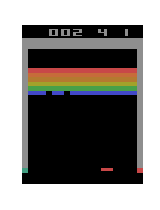
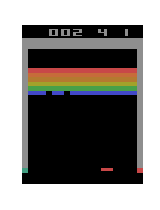
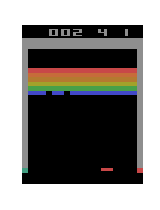
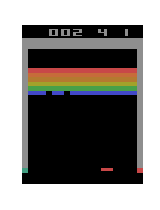
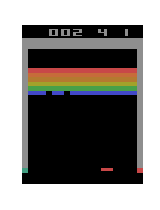
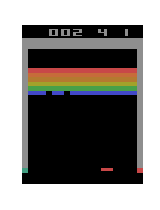
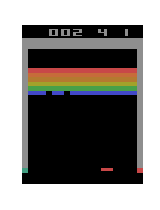
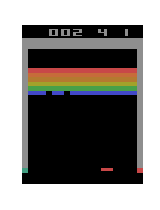
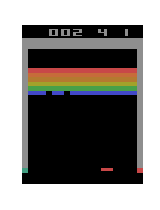
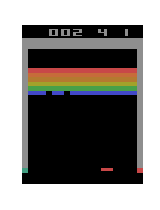
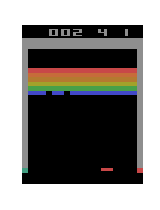
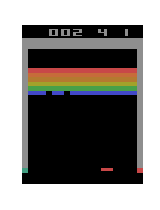
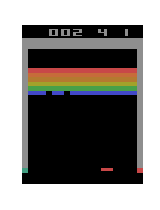
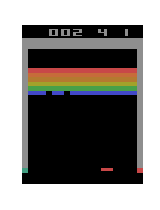
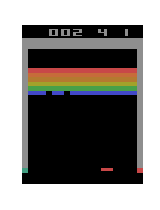
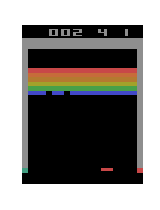
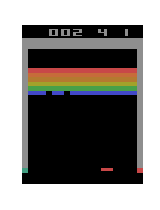
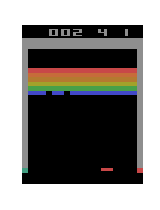
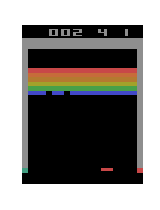
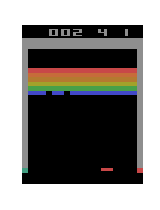
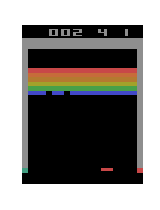
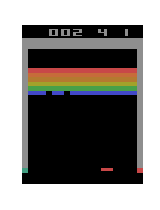
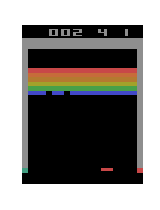
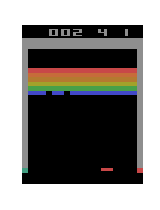
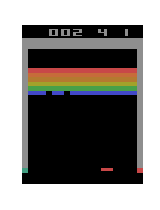
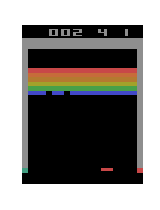
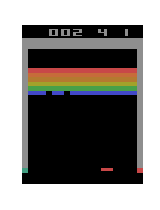
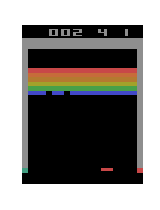
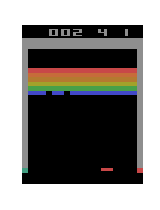
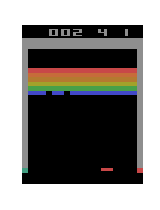
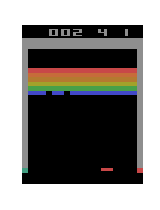
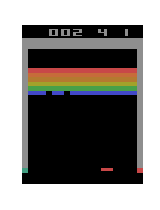
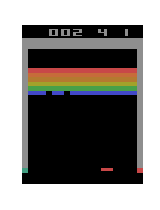
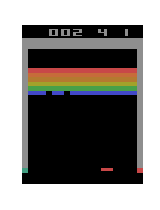
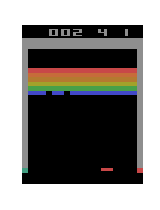
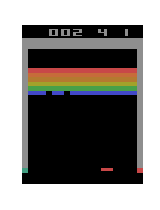
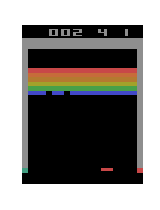
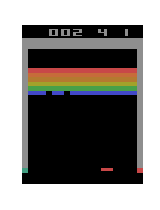
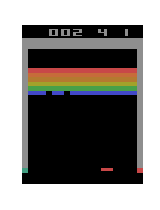
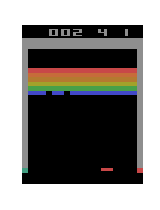
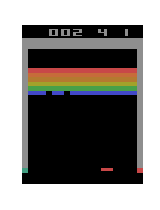
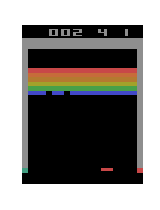
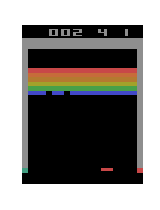
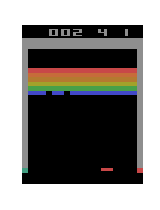
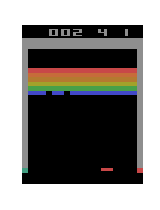
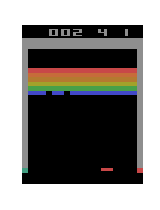
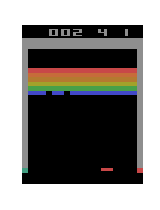
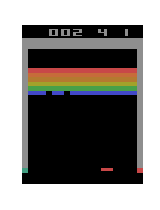
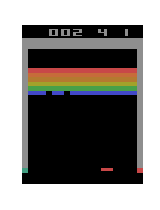
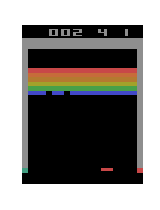
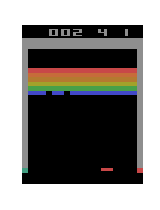
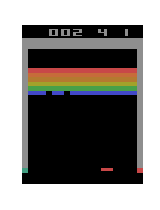
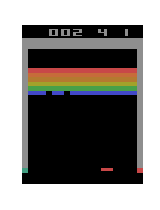
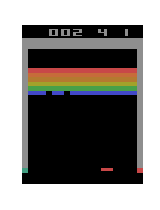
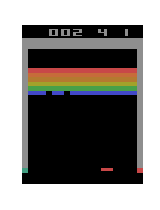
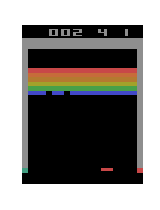
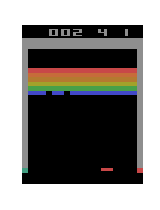
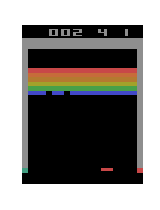
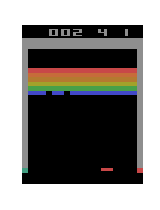
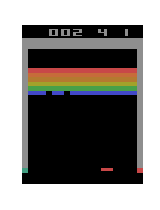
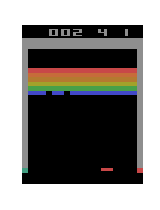
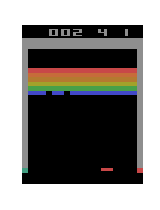
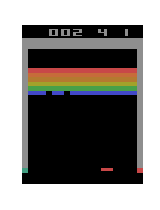
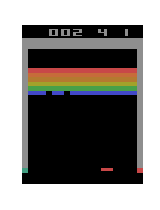
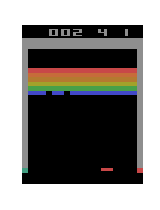
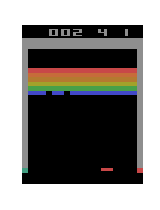
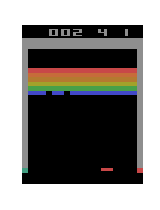
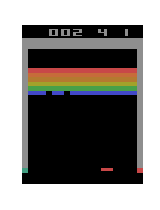
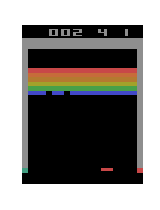
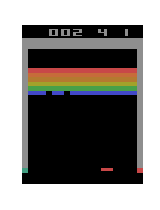
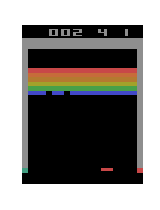
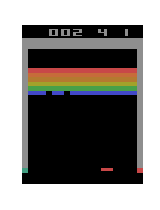
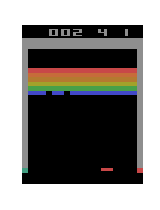
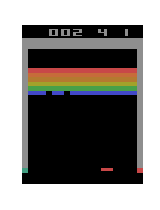
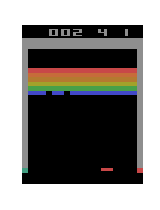
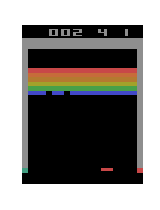
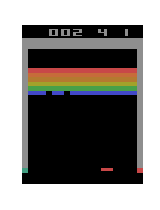
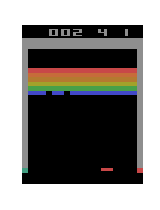
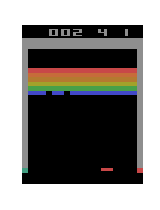
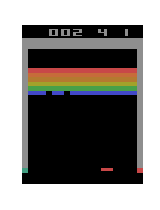
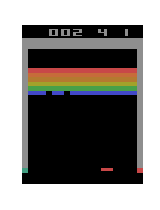
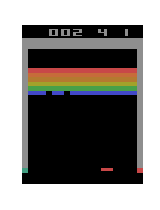
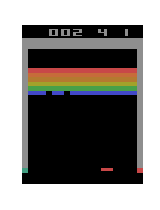
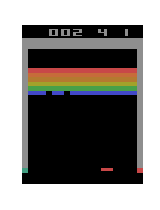
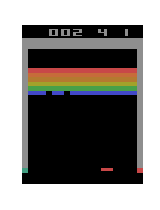
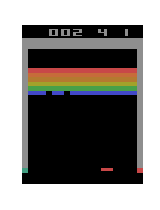
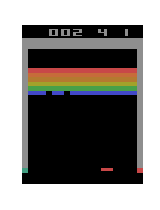
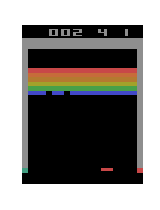
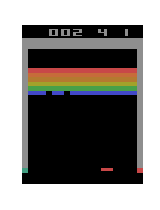
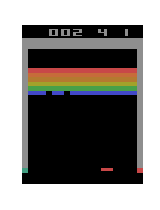
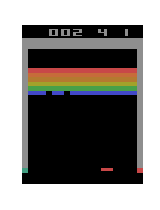
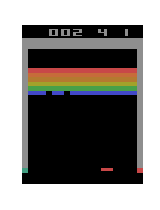
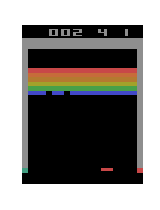
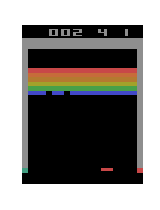
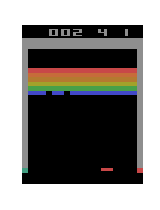
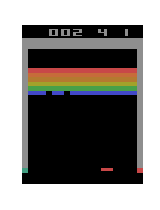
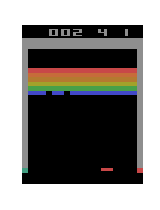
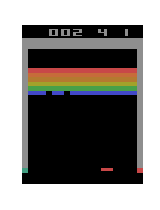
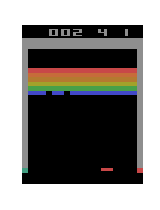
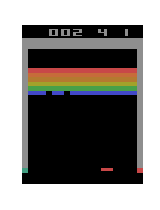
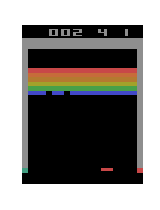
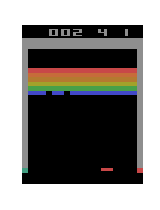
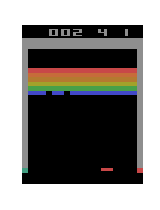
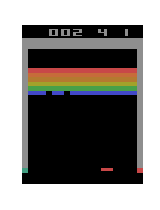
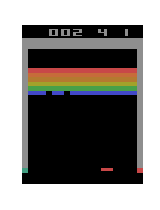
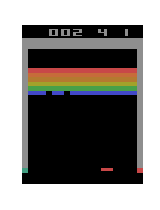
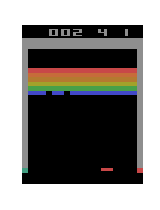
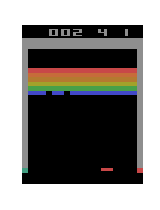
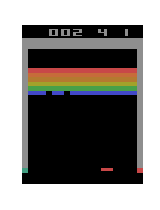
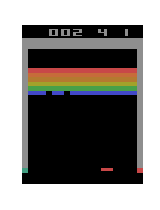
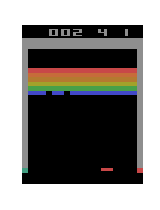
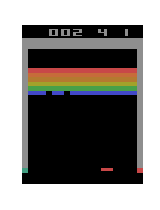
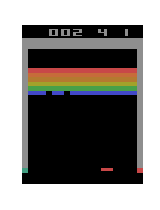
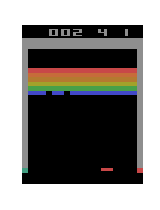
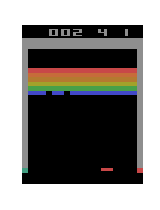
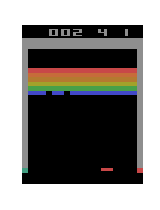
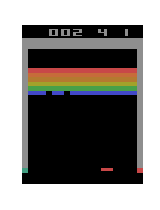
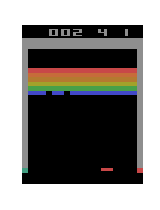
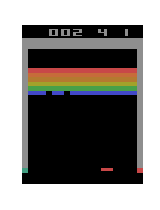
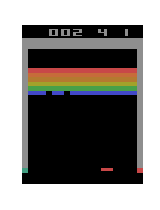
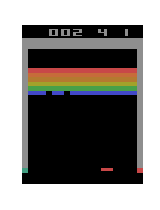
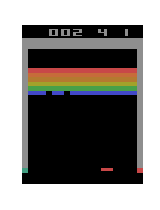
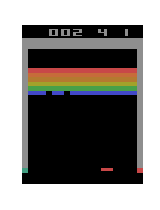
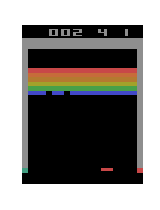
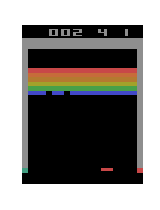
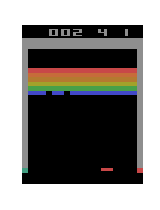
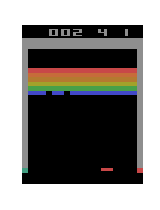
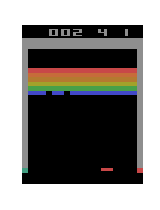
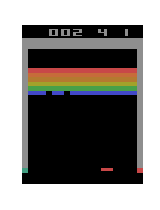
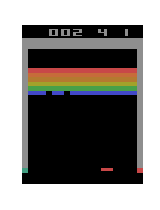
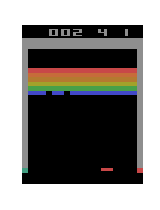
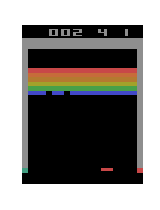
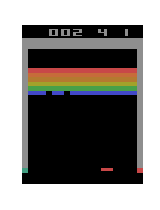
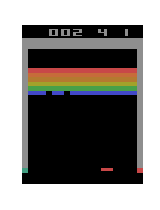
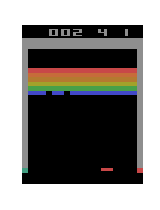
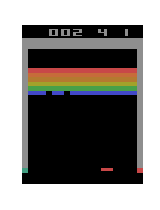
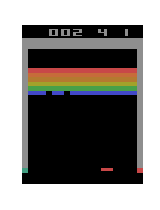
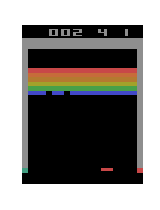
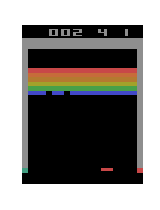
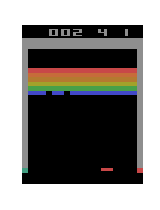
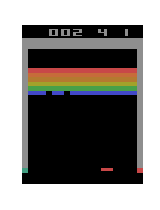
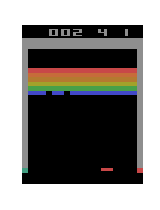
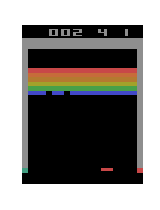
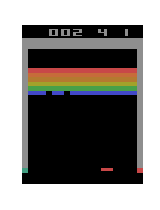
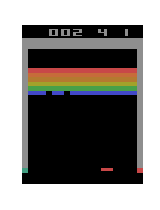
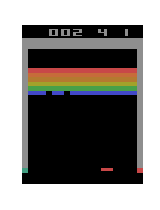
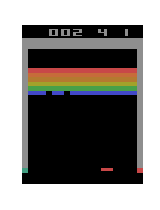
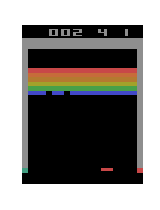
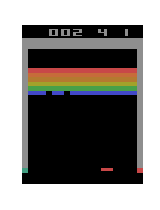
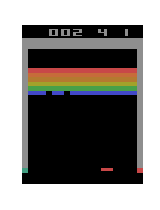
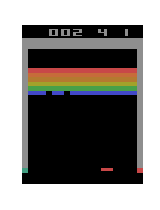
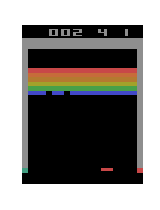
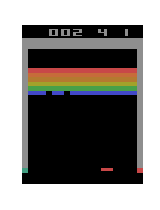
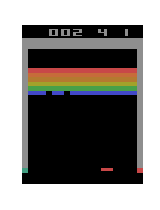
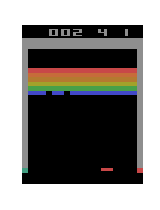
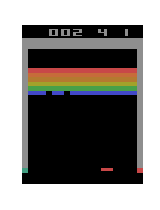
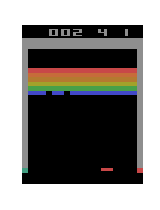
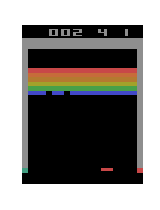
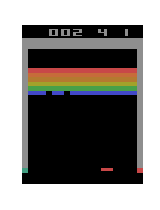
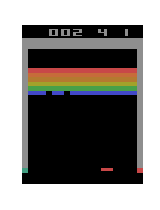
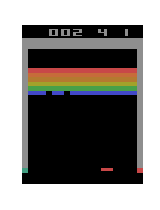
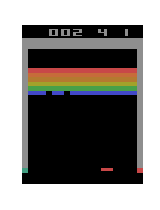
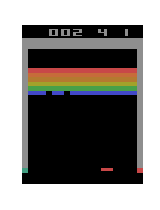
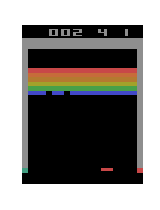
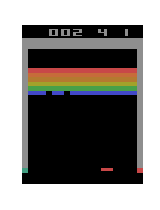
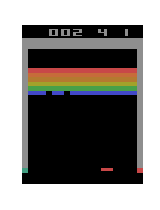
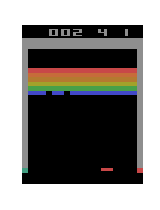
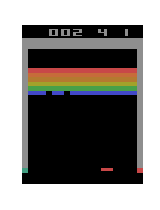
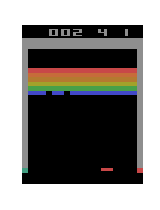
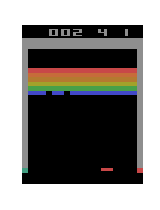
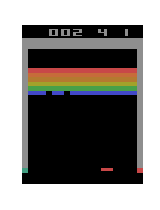
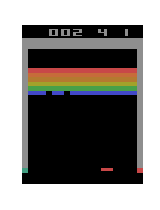
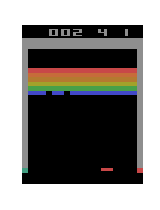
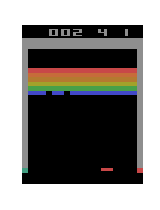
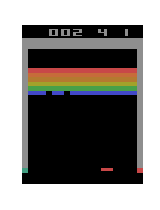
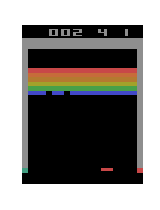
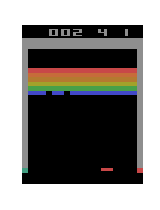
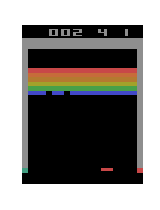
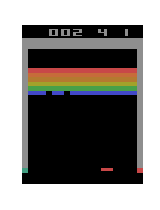
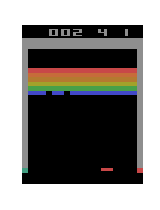
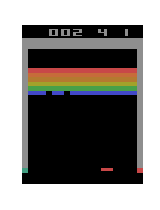
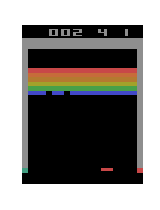
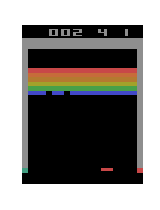
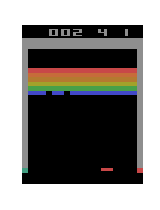
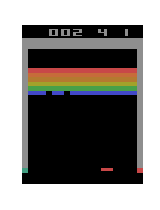
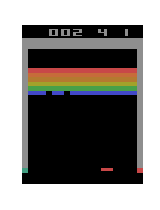
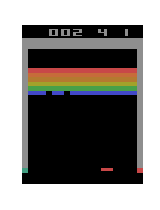
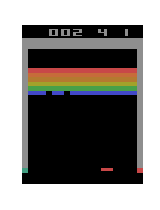
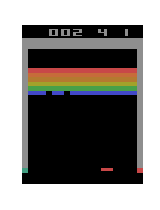
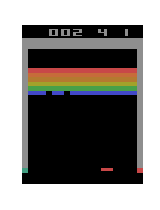
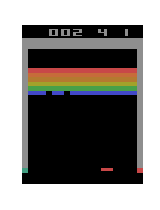
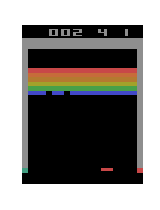
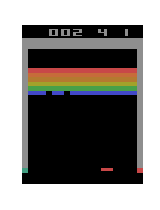
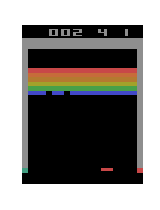
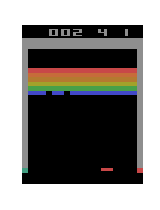
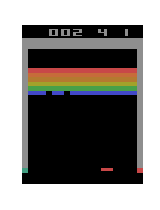
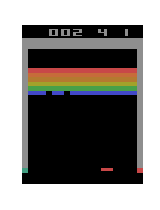
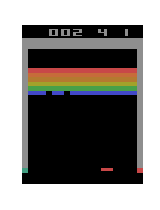
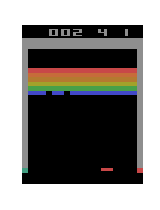

In [25]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
import matplotlib.pyplot as plt
def display_frames_as_gif(frames, filename_gif = None):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename_gif: 
        anim.save(filename_gif, writer = 'imagemagick', fps=20)
    display(display_animation(anim, default_mode='loop'))
display_frames_as_gif(frames[:300], filename_gif="final_performance.gif")

### Conclusion
Hopefully you see a working agent now! Feel free to tweak the neural network, hyperparameters, or the environment the agent is playing. I massively enjoy doing this and seeing the result different decisions have on how well the agent plays. As you found out by now training is slow, so try to keep a diary with your changes and the effect this had on the agent. 

## Thanks for watching!
Hopefully you learned a lot about advanced network configurations for several problems during this course. I mostly hope you had a lot of fun, and know better how to approach problems you encounter yourself!

Remember to check my [blog: pinchofintelligence.com](pinchofintelligence.com) and/or [Twitter](https://twitter.com/rolandmeertens). 